In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import statsmodels.api as sm
from scipy import stats


This notebook is based on the MIT case study on [time series][https://ocw.mit.edu/courses/mathematics/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/case-studies/MIT18_S096F13_CaseStudy3.pdf]

Time Series Penn State [reference](https://online.stat.psu.edu/stat510/).




# Load and clean the data.

In [21]:
# 1.2 Federal Reserve Economic Data (FRED) from the St. Louis Federal Reserve
#       
#
#             Returns historical data for any symbol at the website
#               http://research.stlouisfed.org/fred2/
#
# Series name | Description
# 
# DGS3MO      | 3-Month Treasury, constant maturity rate
# DGS1        | 1-Year Treasury, constant maturity rate
# DGS5        | 5-Year Treasury, constant maturity rate
# DGS10       | 10-Year Treasury, constant maturity rate
#
# DAAA        | Moody's Seasoned Aaa Corporate Bond Yield 
# DBAA        | Moody's Seasoned Baa Corporate Bond Yield 
#
# DCOILWTICO  | Crude Oil Prices: West Text Intermediate (WTI) - Cushing, Oklahoma


# Download the data from the fed: 
from pandas_datareader import data, wb

fredList= ['DGS3MO','DGS1','DGS5','DGS10','DAAA','DBAA','DCOILWTICO']
fredData = data.DataReader(fredList,'fred','2000-01-01','2013-05-31')

# Save the data: 

fredData.rename_axis('Date').to_csv('fredRawData.csv')


In [63]:
# Load the Data: 
fred_raw_data = pd.read_csv('fredRawData.csv',parse_dates=['Date']).set_index('Date')

In [65]:
fred_raw_data.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2013-05-20', '2013-05-21', '2013-05-22', '2013-05-23',
               '2013-05-24', '2013-05-27', '2013-05-28', '2013-05-29',
               '2013-05-30', '2013-05-31'],
              dtype='datetime64[ns]', name='Date', length=3500, freq=None)

In [23]:
# Data Cleaning: 
fred_raw_data.isna().sum()


DGS3MO        144
DGS1          144
DGS5          144
DGS10         144
DAAA          144
DBAA          144
DCOILWTICO    134
dtype: int64

In [66]:
# Our focus is on DGS10, the yield of constant-maturity 10 Year US bond. Let's create a data set with no missing date from 'DGS10'
fred_clean = fred_raw_data[~fred_raw_data['DGS10'].isna()]
fred_clean

,DGS3MO,DGS1,DGS5,DGS10,DAAA,DBAA,DCOILWTICO
Date,,,,,,,
2000-01-03,5.48,6.09,6.50,6.58,7.75,8.27,NaN
2000-01-04,5.43,6.00,6.40,6.49,7.69,8.21,25.56
2000-01-05,5.44,6.05,6.51,6.62,7.78,8.29,24.65
2000-01-06,5.41,6.03,6.46,6.57,7.72,8.24,24.79
2000-01-07,5.38,6.00,6.42,6.52,7.69,8.22,24.79
...,...,...,...,...,...,...,...
2013-05-24,0.04,0.12,0.90,2.01,3.94,4.76,93.84
2013-05-28,0.05,0.13,1.02,2.15,4.06,4.88,94.65
2013-05-29,0.05,0.14,1.02,2.13,4.04,4.88,93.13


In [68]:
# Count how many missing values are still present:
fred_clean.isna().sum()

DGS3MO         0
DGS1           0
DGS5           0
DGS10          0
DAAA           1
DBAA           1
DCOILWTICO    17
dtype: int64

In [79]:
fred_clean['DGS10']

Date
2000-01-03    6.58
2000-01-04    6.49
2000-01-05    6.62
2000-01-06    6.57
2000-01-07    6.52
              ... 
2013-05-24    2.01
2013-05-28    2.15
2013-05-29    2.13
2013-05-30    2.13
2013-05-31    2.16
Name: DGS10, Length: 3356, dtype: float64

In [104]:
DGS10_daily = fred_clean['DGS10']

In [86]:
fred_clean_Weekly= fred_clean.resample('W-FRI').ohlc()
fred_clean_Monthly = fred_clean.resample('M').ohlc()

In [87]:
DGS10_weekly = fred_clean_Weekly['DGS10']
DGS10_weekly

,open,high,low,close
Date,,,,
2000-01-07,6.58,6.62,6.49,6.52
2000-01-14,6.57,6.72,6.57,6.69
2000-01-21,6.75,6.79,6.73,6.79
2000-01-28,6.69,6.70,6.66,6.66
2000-02-04,6.68,6.68,6.49,6.53
...,...,...,...,...
2013-05-03,1.70,1.78,1.66,1.78
2013-05-10,1.80,1.90,1.80,1.90
2013-05-17,1.92,1.96,1.87,1.95


In [81]:
DGS10_Monthly = fred_clean_Monthly['DGS10']

In [82]:
DGS10_Monthly

,open,high,low,close
Date,,,,
2000-01-31,6.58,6.79,6.49,6.68
2000-02-29,6.62,6.67,6.36,6.42
2000-03-31,6.39,6.42,6.03,6.03
2000-04-30,6.00,6.23,5.80,6.23
2000-05-31,6.29,6.57,6.29,6.29
...,...,...,...,...
2013-01-31,1.86,2.03,1.84,2.02
2013-02-28,2.04,2.05,1.88,1.89
2013-03-31,1.86,2.07,1.86,1.87


# The ACF and PACF for daily, weekly, monthly series

In [97]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

Documentation for [ACF][https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html] and [PACF][https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html]

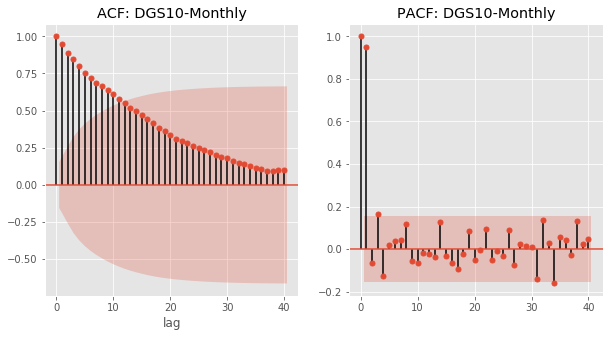

In [161]:
fig, axes = plt.subplots( 1,2, figsize = (10,5))
# ACF
plot_acf(DGS10_Monthly['close'].values,lags=40, ax=axes[0],title='ACF: DGS10-Monthly')
axes[0].set(xlabel='lag')
# PACF
plot_pacf(DGS10_Monthly['close'].values,lags=40,ax=axes[1],title='PACF: DGS10-Monthly')
axes[0].set(xlabel='lag')
plt.show()

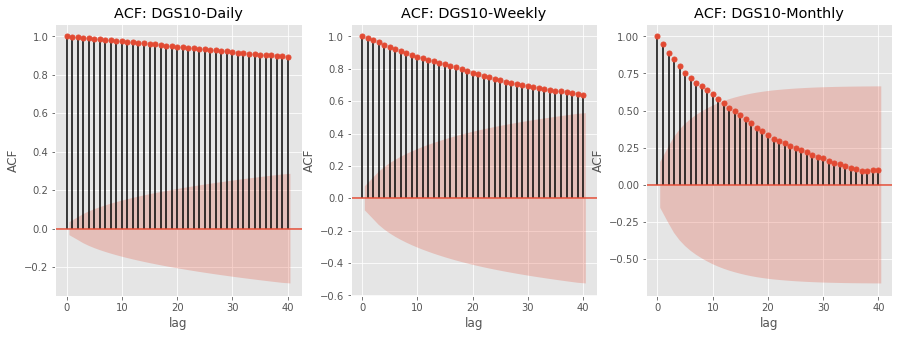

In [180]:
fig, axes = plt.subplots( 1,3, figsize = (15,5))
# Daily
plot_acf(DGS10_daily.values,lags=40, ax=axes[0],title='ACF: DGS10-Daily')
axes[0].set(ylabel='ACF')
axes[0].set(xlabel='lag')
#Weekly
plot_acf(DGS10_weekly['close'].values,lags=40,ax=axes[1],title='ACF: DGS10-Weekly')
axes[1].set(ylabel='ACF')
axes[1].set(xlabel='lag')
# Monthly
plot_acf(DGS10_Monthly['close'].values,lags=40,ax=axes[2],title='ACF: DGS10-Monthly')
axes[2].set(ylabel='ACF')
axes[2].set(xlabel='lag')
plt.show()

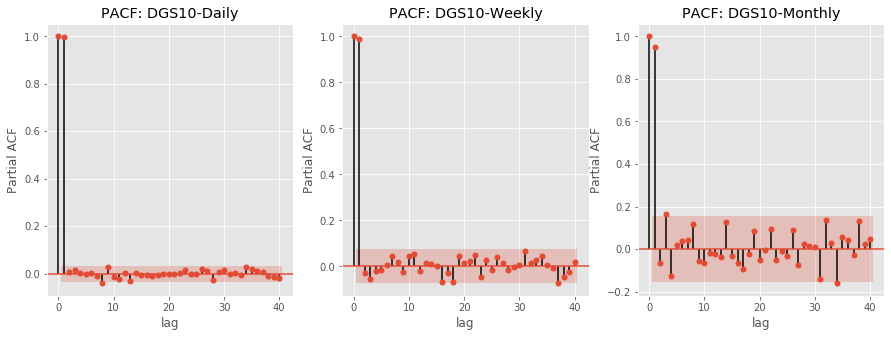

In [168]:
fig, axes = plt.subplots( 1,3, figsize = (15,5))
# Daily
plot_pacf(DGS10_daily.values,lags=40, ax=axes[0],title='PACF: DGS10-Daily')
axes[0].set(ylabel='Partial ACF')
axes[0].set(xlabel='lag')
#Weekly
plot_pacf(DGS10_weekly['close'].values,lags=40,ax=axes[1],title='PACF: DGS10-Weekly')
axes[1].set(ylabel='Partial ACF')
axes[1].set(xlabel='lag')
# Monthly
plot_pacf(DGS10_Monthly['close'].values,lags=40,ax=axes[2],title='PACF: DGS10-Monthly')
axes[2].set(ylabel='Partial ACF')
axes[2].set(xlabel='lag')
plt.show()

# Conduct Augmented Dickey-Fuller Test for Unit Roots

In [109]:
from statsmodels.tsa.stattools import adfuller


Augmented Dickey-Fuller unit root test [documentation][https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html]

In [117]:
adfuller(DGS10_daily.values, maxlag=14, autolag=None)

(-2.125185341905271,
 0.23450876676828092,
 14,
 3341,
 {'1%': -3.4323087941815134,
  '5%': -2.8624054806561885,
  '10%': -2.5672307125909124})

In [122]:
adfuller(DGS10_weekly['close'], autolag='t-stat')

(-1.9183118259161356,
 0.32349628870159486,
 18,
 681,
 {'1%': -3.4399889432093325,
  '5%': -2.865793456189478,
  '10%': -2.5690350878361916},
 2.130149032744437)

In [124]:
adfuller(DGS10_weekly['close'], autolag='AIC')

(-1.9220753092102087,
 0.3217485048691322,
 0,
 699,
 {'1%': -3.439739809554328,
  '5%': -2.86568368980381,
  '10%': -2.5689766074363334},
 -828.3266010136422)

In [125]:
adfuller(DGS10_weekly['close'])

(-1.9220753092102087,
 0.3217485048691322,
 0,
 699,
 {'1%': -3.439739809554328,
  '5%': -2.86568368980381,
  '10%': -2.5689766074363334},
 -828.3266010136422)

# The ACF and PACF for the differenced series of each periodicity

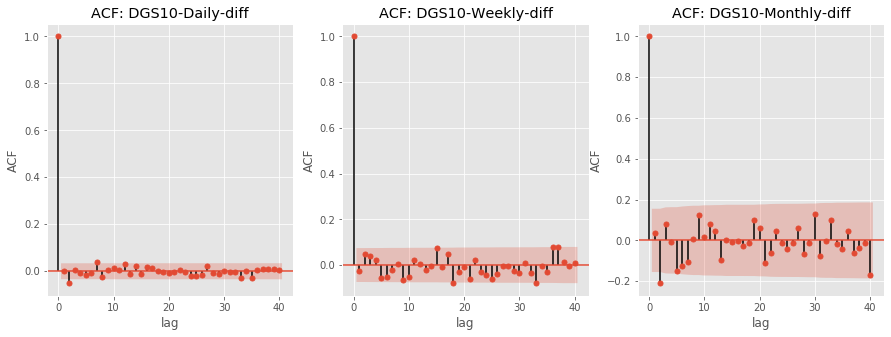

In [178]:
fig, axes = plt.subplots( 1,3, figsize = (15,5))
# Daily
plot_acf(DGS10_daily.diff().values[1:],lags=40, ax=axes[0],title='ACF: DGS10-Daily-diff')
axes[0].set(ylabel='ACF')
axes[0].set(xlabel='lag')
#Weekly
plot_acf(DGS10_weekly['close'].diff().values[1:],lags=40,ax=axes[1],title='ACF: DGS10-Weekly-diff')
axes[1].set(ylabel='ACF')
axes[1].set(xlabel='lag')
# Monthly
plot_acf(DGS10_Monthly['close'].diff().values[1:],lags=40,ax=axes[2],title='ACF: DGS10-Monthly-diff')
axes[2].set(ylabel='ACF')
axes[2].set(xlabel='lag')
plt.show()

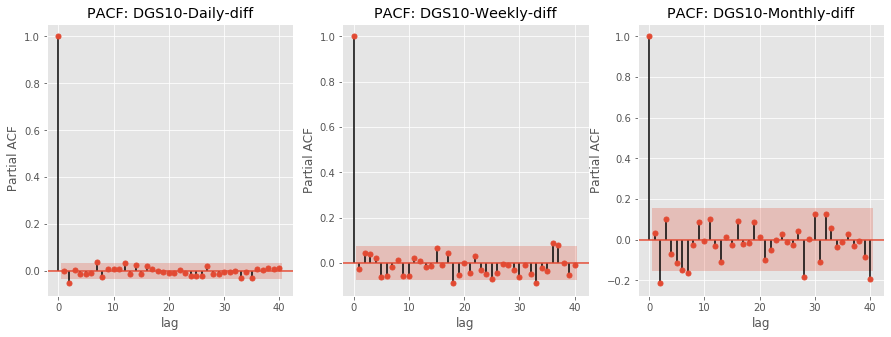

In [220]:
fig, axes = plt.subplots( 1,3, figsize = (15,5))
# Daily
plot_pacf(DGS10_daily.diff().values[1:],lags=40, ax=axes[0],title='PACF: DGS10-Daily-diff')
axes[0].set(ylabel=' Partial ACF')
axes[0].set(xlabel='lag')
#Weekly
plot_pacf(DGS10_weekly['close'].diff().values[1:],lags=40,ax=axes[1],title='PACF: DGS10-Weekly-diff')
axes[1].set(ylabel='Partial ACF')
axes[1].set(xlabel='lag')
# Monthly
plot_pacf(DGS10_Monthly['close'].diff().values[1:],lags=40,ax=axes[2],title='PACF: DGS10-Monthly-diff')
axes[2].set(ylabel='Partial ACF')
axes[2].set(xlabel='lag')
plt.show()

Text(0.5, 1.0, 'DGS10 Monthly diff ')

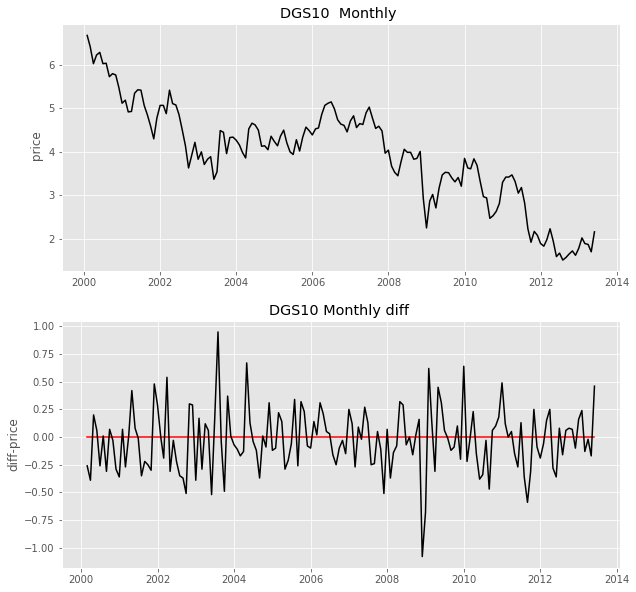

In [210]:
fig, axes = plt.subplots( 2,1, figsize = (10,10))
#----------------------------- DGS10_Monthly----------------------------
axes[0].plot(DGS10_Monthly.index,DGS10_Monthly['close'].values,'black')
axes[0].set_title('DGS10  Monthly ')
axes[0].set(ylabel=' price')
# axes[0].set(xlabel='lag')
#----------------------------- Diff  DGS10_Monthly----------------------------
axes[1].plot(DGS10_Monthly.diff().index[1:],DGS10_Monthly['close'].diff().values[1:]*0,'red')
axes[1].plot(DGS10_Monthly.diff().index[1:],DGS10_Monthly['close'].diff().values[1:],'black')
axes[1].set(ylabel='diff-price')
axes[1].set_title('DGS10 Monthly diff ')
# axes[1].set(xlabel='lag')

# 1.6 Understanding partial autocorrelation coefficients

In [212]:
from statsmodels.graphics.tsaplots import acf
from statsmodels.graphics.tsaplots import pacf

In [229]:
y0 = DGS10_Monthly['close'].diff().values[1:]

In [231]:
acf(y0,fft=True,nlags=10)

array([ 1.        ,  0.03509773, -0.21102318,  0.07890662, -0.01001433,
       -0.14862295, -0.12408855, -0.10572507,  0.0059754 ,  0.12465932,
        0.01540959])

In [230]:
pacf(y0,nlags=10)

array([ 1.        ,  0.03531847, -0.21521021,  0.10203404, -0.07003868,
       -0.11571323, -0.14792214, -0.16463709, -0.02853224,  0.08747502,
       -0.00547812])

In [237]:
pd.DataFrame.from_dict({'acf':acf(y0,fft=True,nlags=10),'pacf':pacf(y0,nlags=10)})

,acf,pacf
0,1.000000,1.000000
1,0.035098,0.035318
2,-0.211023,-0.215210
3,0.078907,0.102034
4,-0.010014,-0.070039
5,-0.148623,-0.115713
6,-0.124089,-0.147922
7,-0.105725,-0.164637
8,0.005975,-0.028532
9,0.124659,0.087475


In [251]:
# Plot y0[t]  =  beta*y[t+1]   (we need to remove the the last valeu of y0, for y0 and y0[t-1] to have the same size. ) 
lag1_results = sm.OLS(y0[:-1],y0[1:]).fit()

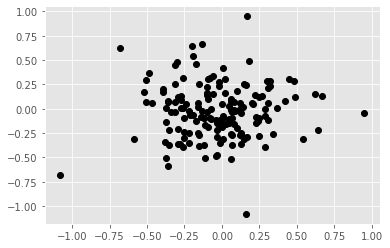

In [247]:
plt.plot(y0[:-1],y0[1:],'ok')

In [257]:
print(lag1_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):             -0.004
Method:                 Least Squares   F-statistic:                             0.3336
Date:                Fri, 19 Mar 2021   Prob (F-statistic):                       0.564
Time:                        22:11:13   Log-Likelihood:                         -22.495
No. Observations:                 159   AIC:                                      46.99
Df Residuals:                     158   BIC:                                      50.06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------